In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from typing import Dict, Tuple
from scipy.stats import norm, invgamma, multivariate_normal

warnings.filterwarnings('ignore')

from regime_detection import KAMA
from regime_detection import MarkovSwitchingModel

Matplotlib is building the font cache; this may take a moment.


# Testing KAMA

In [49]:
symbol_name_dict = pd.read_csv('data/inputs/fmp_index_list.csv').set_index('symbol')['name'].to_dict()
index_data = pd.read_csv('data/processed/index_data.csv', index_col=0, header=[0, 1], parse_dates=True)

close_cols = index_data.columns[index_data.columns.get_level_values(1) == 'close']
index_close_prices = index_data[close_cols].droplevel(1, axis=1).rename(columns=symbol_name_dict)

In [50]:
sp500_prices = index_close_prices['S&P 500'].dropna()
kama = KAMA(n=10, n_fast=2, n_slow=30)
sp500_kama = kama.calculate_kama(sp500_prices)
# pd.concat([sp500_prices, sp500_kama[0], sp500_kama[1], sp500_kama[2]], axis=1).head(11)

In [53]:
px.line(pd.concat([sp500_prices, sp500_kama[0]], axis=1).tail(252*5))

# Testing MSR

In [ ]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

### Testing & Analytics Functions

In [107]:
def analyze_model_results(model, data, true_params=None, data_name="Data"):
    """
    Comprehensive analysis of model results
    """
    print(f"\n{'='*60}")
    print(f"ANALYSIS RESULTS FOR {data_name.upper()}")
    print(f"{'='*60}")
    
    # Get regime probabilities
    regime_probs = model.get_regime_probabilities(data['returns'])
    
    # Parameter estimates
    print(f"\nEstimated Parameters:")
    print(f"{'Regime':<8} {'μ (Mean)':<12} {'β (AR)':<10} {'σ (Vol)':<12}")
    print("-" * 45)
    for i in range(2):
        print(f"Regime {i:<2} {model.means[i]:<11.6f} {model.stds[i]:<9.4f} {model.stds[i]:<11.6f}")
    
    print(f"\nTransition Probabilities:")
    print(f"From\\To   Regime 0   Regime 1")
    print(f"Regime 0    {model.transition_probs[0,0]:.3f}      {model.transition_probs[0,1]:.3f}")
    print(f"Regime 1    {model.transition_probs[1,0]:.3f}      {model.transition_probs[1,1]:.3f}")
    
    # Expected regime durations
    duration_0 = 1 / (1 - model.transition_probs[0,0])
    duration_1 = 1 / (1 - model.transition_probs[1,1])
    print(f"\nExpected Regime Durations:")
    print(f"Regime 0 (Low Vol): {duration_0:.1f} days")
    print(f"Regime 1 (High Vol): {duration_1:.1f} days")
    
    # Compare with true parameters if available
    if true_params is not None:
        print(f"\n{'='*30}")
        print("TRUE vs ESTIMATED COMPARISON")
        print(f"{'='*30}")
        
        print(f"\n{'Parameter':<15} {'True':<10} {'Estimated':<12} {'Error':<8}")
        print("-" * 50)
        for i in range(2):
            mu_error = abs(true_params['means'][i] - model.means[i])
            beta_error = abs(true_params['stds'][i] - model.betas[i])
            std_error = abs(true_params['stds'][i] - model.stds[i])
            
            print(f"μ_{i}             {true_params['means'][i]:<10.6f} {model.means[i]:<12.6f} {mu_error:<8.6f}")
            print(f"β_{i}             {true_params['betas'][i]:<10.4f} {model.betas[i]:<12.4f} {beta_error:<8.4f}")
            print(f"σ_{i}             {true_params['stds'][i]:<10.6f} {model.stds[i]:<12.6f} {std_error:<8.6f}")
    
    # Regime classification
    estimated_regimes = (regime_probs['Regime_1'] > 0.5).astype(int)
    
    print(f"\nRegime Classification:")
    print(f"Estimated Regime 0 periods: {(estimated_regimes == 0).sum()} days ({(estimated_regimes == 0).mean():.1%})")
    print(f"Estimated Regime 1 periods: {(estimated_regimes == 1).sum()} days ({(estimated_regimes == 1).mean():.1%})")
    
    if 'true_regime' in data.columns:
        accuracy = (estimated_regimes.values == data['true_regime'].values).mean()
        print(f"Classification Accuracy: {accuracy:.2%}")
    
    # Volatility analysis
    regime_0_returns = data['returns'][regime_probs['Regime_0'] > 0.5]
    regime_1_returns = data['returns'][regime_probs['Regime_1'] > 0.5]
    
    if len(regime_0_returns) > 0 and len(regime_1_returns) > 0:
        vol_0 = regime_0_returns.std() * np.sqrt(252)  # Annualized
        vol_1 = regime_1_returns.std() * np.sqrt(252)  # Annualized
        
        print(f"\nEmpirical Regime Statistics:")
        print(f"Regime 0 - Mean: {regime_0_returns.mean():.6f}, Vol: {vol_0:.2%}")
        print(f"Regime 1 - Mean: {regime_1_returns.mean():.6f}, Vol: {vol_1:.2%}")
    
    return regime_probs

def create_comprehensive_plots(data, regime_probs, model, true_params=None, data_name="Data"):
    """
    Create comprehensive visualization plots
    """
    fig = plt.figure(figsize=(16, 12))
    
    # Plot 1: Returns time series with regime highlighting
    ax1 = plt.subplot(3, 2, 1)
    ax1.plot(data.index, data['returns'], color='black', alpha=0.7, linewidth=0.5)
    
    # Highlight high volatility periods
    high_vol_mask = regime_probs['Regime_1'] > 0.5
    ax1.fill_between(data.index, data['returns'].min(), data['returns'].max(),
                     where=high_vol_mask, alpha=0.3, color='red', 
                     label='High Vol Regime')
    
    ax1.set_title(f'{data_name}: Returns with Estimated Regimes')
    ax1.set_ylabel('Daily Log Returns')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Regime probabilities over time
    ax2 = plt.subplot(3, 2, 2)
    ax2.plot(regime_probs.index, regime_probs['Regime_0'], 
             label='Low Vol Regime', color='blue', alpha=0.8)
    ax2.plot(regime_probs.index, regime_probs['Regime_1'], 
             label='High Vol Regime', color='red', alpha=0.8)
    ax2.set_title('Regime Probabilities Over Time')
    ax2.set_ylabel('Probability')
    ax2.set_ylim(0, 1)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: True vs Estimated regimes (if available)
    if 'true_regime' in data.columns:
        ax3 = plt.subplot(3, 2, 3)
        ax3.plot(data.index, data['true_regime'], 
                 label='True Regime', color='green', linewidth=2, alpha=0.8)
        estimated_regime = (regime_probs['Regime_1'] > 0.5).astype(int)
        ax3.plot(regime_probs.index, estimated_regime, 
                 label='Estimated Regime', color='orange', linestyle='--', alpha=0.8)
        ax3.set_title('True vs Estimated Regime Sequence')
        ax3.set_ylabel('Regime')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # Plot 4: Return distribution by regime
    ax4 = plt.subplot(3, 2, 4)
    regime_0_returns = data['returns'][regime_probs['Regime_0'] > 0.5]
    regime_1_returns = data['returns'][regime_probs['Regime_1'] > 0.5]
    
    if len(regime_0_returns) > 0:
        ax4.hist(regime_0_returns, bins=50, alpha=0.6, color='blue', 
                 label=f'Regime 0 (n={len(regime_0_returns)})', density=True)
    if len(regime_1_returns) > 0:
        ax4.hist(regime_1_returns, bins=50, alpha=0.6, color='red', 
                 label=f'Regime 1 (n={len(regime_1_returns)})', density=True)
    
    ax4.set_title('Return Distributions by Regime')
    ax4.set_xlabel('Daily Returns')
    ax4.set_ylabel('Density')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Parameter posterior distributions (if MCMC samples available)
    if hasattr(model, 'mcmc_samples') and model.mcmc_samples is not None:
        ax5 = plt.subplot(3, 2, 5)
        
        # Plot mean parameters
        ax5.hist(model.mcmc_samples['means'][:, 0], bins=30, alpha=0.6, 
                 label='μ_0', color='blue', density=True)
        ax5.hist(model.mcmc_samples['means'][:, 1], bins=30, alpha=0.6, 
                 label='μ_1', color='red', density=True)
        
        if true_params is not None:
            ax5.axvline(true_params['means'][0], color='blue', linestyle='--', 
                       label='True μ_0')
            ax5.axvline(true_params['means'][1], color='red', linestyle='--', 
                       label='True μ_1')
        
        ax5.set_title('Posterior Distributions of Mean Parameters')
        ax5.set_xlabel('Mean Parameter Value')
        ax5.set_ylabel('Density')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
    
    # Plot 6: Rolling volatility
    ax6 = plt.subplot(3, 2, 6)
    
    # Calculate rolling volatility
    window = 30
    rolling_vol = data['returns'].rolling(window=window).std() * np.sqrt(252)
    
    ax6.plot(data.index, rolling_vol, color='black', alpha=0.7, 
             label=f'{window}-day Rolling Vol')
    ax6.fill_between(data.index, 0, rolling_vol.max(),
                     where=regime_probs['Regime_1'] > 0.5, alpha=0.3, color='red', 
                     label='High Vol Regime')
    
    ax6.set_title('Rolling Volatility vs Regime Detection')
    ax6.set_ylabel('Annualized Volatility')
    ax6.set_xlabel('Date')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def compare_regime_characteristics(regime_probs, data, data_name="Data"):
    """
    Detailed comparison of regime characteristics
    """
    print(f"\n{'='*50}")
    print(f"DETAILED REGIME ANALYSIS - {data_name.upper()}")
    print(f"{'='*50}")
    
    # Classify observations by most likely regime
    regime_classification = (regime_probs['Regime_1'] > 0.5).astype(int)
    
    # Calculate regime-specific statistics
    for regime in [0, 1]:
        mask = regime_classification == regime
        regime_returns = data['returns'][mask]
        
        if len(regime_returns) > 0:
            regime_name = "Low Volatility" if regime == 0 else "High Volatility"
            print(f"\n{regime_name} Regime (Regime {regime}):")
            print(f"  Observations: {len(regime_returns)} ({len(regime_returns)/len(data)*100:.1f}%)")
            print(f"  Mean Return: {regime_returns.mean():.6f} ({regime_returns.mean()*252:.2%} annualized)")
            print(f"  Volatility: {regime_returns.std():.6f} ({regime_returns.std()*np.sqrt(252):.2%} annualized)")
            print(f"  Min Return: {regime_returns.min():.6f}")
            print(f"  Max Return: {regime_returns.max():.6f}")
            print(f"  Skewness: {regime_returns.skew():.3f}")
            print(f"  Excess Kurtosis: {regime_returns.kurtosis():.3f}")
    
    # Regime switching frequency
    regime_changes = np.diff(regime_classification).astype(bool).sum()
    print(f"\nRegime Switching Frequency:")
    print(f"  Number of regime changes: {regime_changes}")
    print(f"  Average regime duration: {len(data)/(regime_changes+1):.1f} days")
    
    return regime_classification

def model_diagnostics(model, data, regime_probs, data_name="Data"):
    """
    Perform model diagnostics and validation
    """
    print(f"\n{'='*50}")
    print(f"MODEL DIAGNOSTICS - {data_name.upper()}")
    print(f"{'='*50}")
    
    if model.mcmc_samples is not None:
        # Convergence diagnostics
        print(f"\nMCMC Convergence Diagnostics:")
        print(f"Number of samples: {len(model.mcmc_samples['means'])}")
        
        # Parameter stability (rough check)
        means_0 = model.mcmc_samples['means'][:, 0]
        means_1 = model.mcmc_samples['means'][:, 1]
        betas_0 = model.mcmc_samples['betas'][:, 0]
        betas_1 = model.mcmc_samples['betas'][:, 1]
        stds_0 = model.mcmc_samples['stds'][:, 0]
        stds_1 = model.mcmc_samples['stds'][:, 1]
        tprobs_0 = model.mcmc_samples['transition_probs'][:, 0]
        tprobs_1 = model.mcmc_samples['transition_probs'][:, 1]
        
        # Check if parameters are stable in second half vs first half
        mid_point_means_0 = len(means_0) // 2
        first_half_means_0 = np.mean(means_0[:mid_point_means_0])
        second_half_means_0 = np.mean(means_0[mid_point_means_0:])
        mid_point_means_1 = len(means_1) // 2
        first_half_means_1 = np.mean(means_1[:mid_point_means_1])
        second_half_means_1 = np.mean(means_1[mid_point_means_1:])

        mid_point_betas_0 = len(betas_0) // 2
        first_half_betas_0 = np.mean(betas_0[:mid_point_betas_0])
        second_half_betas_0 = np.mean(betas_0[mid_point_betas_0:])
        mid_point_betas_1 = len(betas_1) // 2
        first_half_betas_1 = np.mean(betas_1[:mid_point_betas_1])
        second_half_betas_1 = np.mean(betas_1[mid_point_betas_1:])

        mid_point_stds_0 = len(stds_0) // 2
        first_half_stds_0 = np.mean(stds_0[:mid_point_stds_0])
        second_half_stds_0 = np.mean(stds_0[mid_point_stds_0:])
        mid_point_stds_1 = len(stds_1) // 2
        first_half_stds_1 = np.mean(stds_1[:mid_point_stds_1])
        second_half_stds_1 = np.mean(stds_1[mid_point_stds_1:])

        # mid_point_tprobs_0 = len(tprobs_0) // 2
        # first_half_tprobs_0 = np.mean(tprobs_0[:mid_point_tprobs_0])
        # second_half_tprobs_0 = np.mean(tprobs_0[mid_point_tprobs_0:])
        # mid_point_tprobs_1 = len(tprobs_1) // 2
        # first_half_tprobs_1 = np.mean(tprobs_1[:mid_point_tprobs_1])
        # second_half_tprobs_1 = np.mean(tprobs_1[mid_point_tprobs_1:])
        
        print(f"μ_0 stability: First half = {first_half_means_0:.6f}, " f"Second half = {second_half_means_0:.6f}")
        print(f"μ_1 stability: First half = {first_half_means_1:.6f}, " f"Second half = {second_half_means_1:.6f}")
        print(f"β_0 stability: First half = {first_half_betas_0:.6f}, " f"Second half = {second_half_betas_0:.6f}")
        print(f"β_1 stability: First half = {first_half_betas_1:.6f}, " f"Second half = {second_half_betas_1:.6f}")
        print(f"σ_0 stability: First half = {first_half_stds_0:.6f}, " f"Second half = {second_half_stds_0:.6f}")
        print(f"σ_1 stability: First half = {first_half_stds_1:.6f}, " f"Second half = {second_half_stds_1:.6f}")
        # print(f"transitons_probs_0 stability: First half = {first_half_tprobs_0:.6f}, " f"Second half = {second_half_tprobs_0:.6f}")
        # print(f"transition_probs_1 stability: First half = {first_half_tprobs_1:.6f}, " f"Second half = {second_half_tprobs_1:.6f}")
        
        # Plot trace plots
        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        
        # Trace plots for means
        axes[0, 0].plot(model.mcmc_samples['means'][:, 0])
        axes[0, 0].set_title('Trace Plot: μ_0')
        axes[0, 0].grid(True, alpha=0.3)
        
        axes[0, 1].plot(model.mcmc_samples['means'][:, 1])
        axes[0, 1].set_title('Trace Plot: μ_1')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Trace plots for betas
        axes[0, 2].plot(model.mcmc_samples['betas'][:, 0])
        axes[0, 2].set_title('Trace Plot: β_0')
        axes[0, 2].grid(True, alpha=0.3)
        
        axes[1, 0].plot(model.mcmc_samples['betas'][:, 1])
        axes[1, 0].set_title('Trace Plot: β_1')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Trace plots for standard deviations
        axes[1, 1].plot(model.mcmc_samples['stds'][:, 0])
        axes[1, 1].set_title('Trace Plot: σ_0')
        axes[1, 1].grid(True, alpha=0.3)
        
        axes[1, 2].plot(model.mcmc_samples['stds'][:, 1])
        axes[1, 2].set_title('Trace Plot: σ_1')
        axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # Model fit statistics
    returns = data['returns'].values
    regime_0_mask = regime_probs['Regime_0'] > 0.5
    regime_1_mask = regime_probs['Regime_1'] > 0.5
    
    # Calculate log-likelihood (approximate)
    log_likelihood = 0
    for t in range(1, len(returns)):
        if regime_0_mask.iloc[t]:
            mean = model.means[0] + model.betas[0] * returns[t-1]
            ll = norm.logpdf(returns[t], mean, model.stds[0])
        else:
            mean = model.means[1] + model.betas[1] * returns[t-1]
            ll = norm.logpdf(returns[t], mean, model.stds[1])
        log_likelihood += ll
    
    print(f"\nModel Fit Statistics:")
    print(f"Approximate Log-Likelihood: {log_likelihood:.2f}")
    
    # AIC approximation (assuming 8 parameters: 2 means, 2 betas, 2 stds, 2 transition probs)
    n_params = 8
    aic = 2 * n_params - 2 * log_likelihood
    print(f"AIC (approximate): {aic:.2f}")


### Run Testing

##### Fit Model


TESTING ON S&P 500 DATA
Start Date: 1995-01-01, End Date: 2025-09-26
Fitting model on S&P 500 data...
Running Gibbs sampler: 275 total iterations
Burnin: 75, Samples: 200, Thin: 1
Iteration 200/275
Iteration 200/275
Gibbs sampling completed!
Regime 0: μ=0.0009, β=-0.0012, σ=0.0068
Regime 1: μ=-0.0009, β=-0.0240, σ=0.0185

ANALYSIS RESULTS FOR S&P 500

Estimated Parameters:
Regime   μ (Mean)     β (AR)     σ (Vol)     
---------------------------------------------
Regime 0  0.000929    -0.0012   0.006831   
Regime 1  -0.000903   -0.0240   0.018549   

Transition Probabilities:
From\To   Regime 0   Regime 1
Regime 0    0.982      0.018
Regime 1    0.038      0.962

Expected Regime Durations:
Regime 0 (Low Vol): 56.6 days
Regime 1 (High Vol): 26.4 days

Regime Classification:
Estimated Regime 0 periods: 5313 days (68.7%)
Estimated Regime 1 periods: 2423 days (31.3%)

Empirical Regime Statistics:
Regime 0 - Mean: 0.000933, Vol: 10.79%
Regime 1 - Mean: -0.000934, Vol: 29.69%
Gibbs sampling

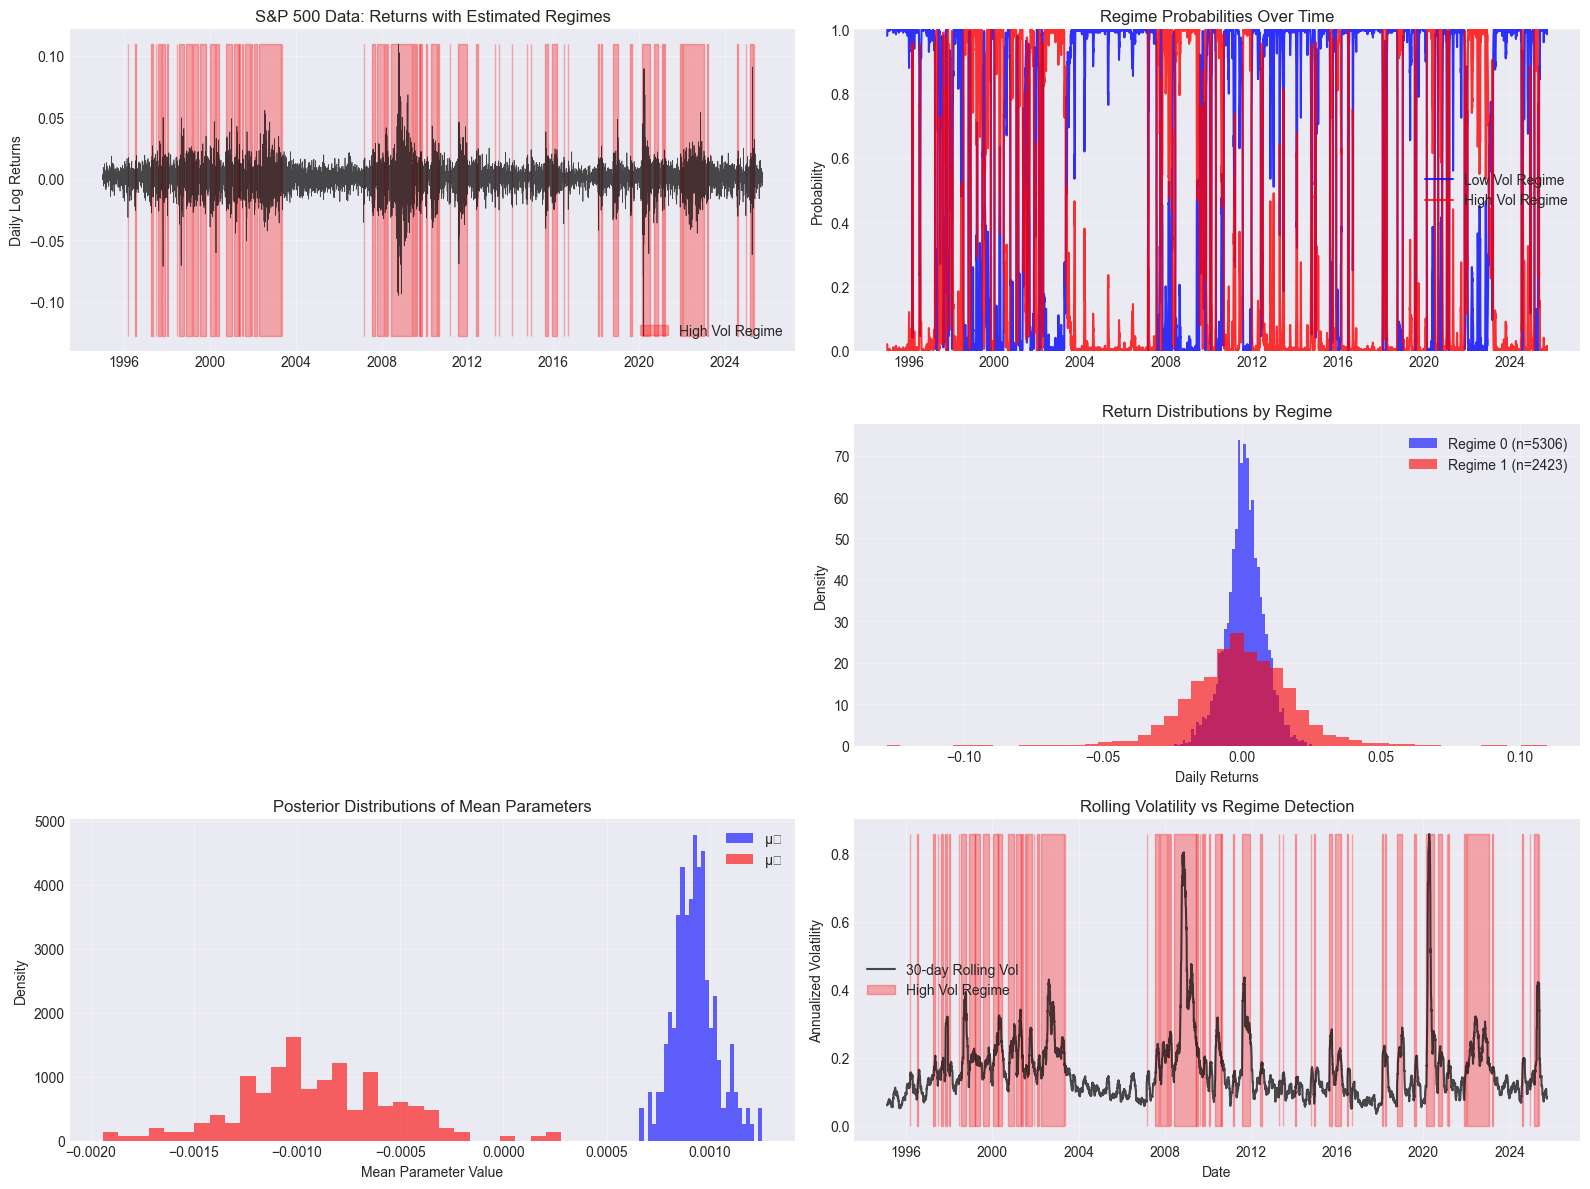

In [38]:
sdte = datetime(1995, 1, 1)
edte = sp500_prices.index[-1]
print("\nTESTING ON S&P 500 DATA")
print(f"Start Date: {sdte.strftime('%Y-%m-%d')}, End Date: {edte.strftime('%Y-%m-%d')}")
print("="*50)

sp500_log_returns = np.log(sp500_prices).diff().dropna()
sp500_log_returns = pd.DataFrame({'returns': sp500_log_returns.loc[sdte:edte]})

msr_model = MarkovSwitchingModel(n_regimes=2)

# Set priors appropriate for market data
msr_model.set_priors(
    mean_prior_mean=0.0,
    mean_prior_var=0.01,
    beta_prior_mean=0.0,
    beta_prior_var=0.3,
    sigma_prior_shape=3.0,
    sigma_prior_scale=0.0001,
    transition_prior_alpha=8.0
)

print("Fitting model on S&P 500 data...")
msr_model.fit(sp500_log_returns['returns'], n_samples=200, burnin=75, verbose=True)

# Analyze results
regime_probs = analyze_model_results(msr_model, sp500_log_returns, 
                                         data_name="S&P 500")

# Create plots
create_comprehensive_plots(sp500_log_returns, regime_probs, msr_model, 
                          data_name="S&P 500 Data")


##### Regime Analysis

In [59]:
regime_classification = compare_regime_characteristics(
    regime_probs, sp500_log_returns, "S&P 500")


DETAILED REGIME ANALYSIS - S&P 500

Low Volatility Regime (Regime 0):
  Observations: 5313 (68.7%)
  Mean Return: 0.000929 (23.40% annualized)
  Volatility: 0.006798 (10.79% annualized)
  Min Return: -0.024427
  Max Return: 0.025086
  Skewness: -0.117
  Excess Kurtosis: 0.530

High Volatility Regime (Regime 1):
  Observations: 2423 (31.3%)
  Mean Return: -0.000934 (-23.53% annualized)
  Volatility: 0.018705 (29.69% annualized)
  Min Return: -0.127652
  Max Return: 0.109572
  Skewness: -0.116
  Excess Kurtosis: 3.871

Regime Switching Frequency:
  Number of regime changes: 128
  Average regime duration: 60.0 days


##### Model Diagnositics


MODEL DIAGNOSTICS - S&P 500

MCMC Convergence Diagnostics:
Number of samples: 200
μ_0 stability: First half = 0.000921, Second half = 0.000937
μ_1 stability: First half = -0.000933, Second half = -0.000874
β_0 stability: First half = -0.001123, Second half = -0.001369
β_1 stability: First half = -0.024504, Second half = -0.023482
σ_0 stability: First half = 0.006877, Second half = 0.006785
σ_1 stability: First half = 0.018618, Second half = 0.018480


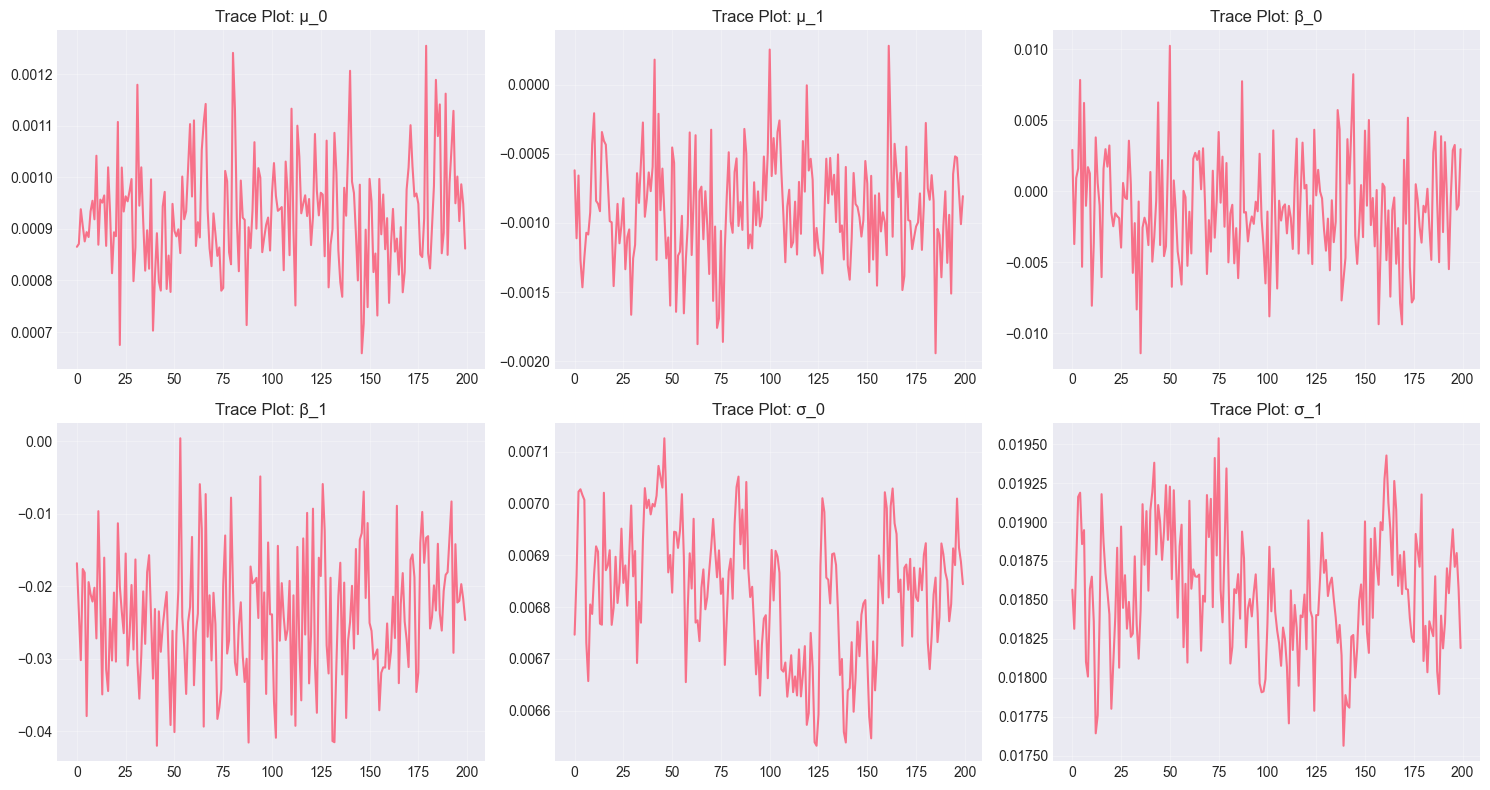


Model Fit Statistics:
Approximate Log-Likelihood: 25180.33
AIC (approximate): -50344.66

TESTING COMPLETE!


In [108]:
model_diagnostics(msr_model, sp500_log_returns, regime_probs, "S&P 500")

print("\n" + "="*70)
print("TESTING COMPLETE!")
print("="*70)